In [2]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Traffic Data Wrangling") \
    .getOrCreate()

# Load the cleaned data
df = spark.read.csv("s3a://final-project-group-14/cleaned_traffic_data.csv", header=True, inferSchema=True)


In [3]:
df.show(5)  # Show the first 5 rows
df.printSchema()  # Print the schema of the DataFrame

+-------+--------+-------------------+-------------------+---------+-------------------+------------+---------------+---------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|     ID|Severity|         Start_Time|           End_Time|Start_Lat|          Start_Lng|Distance(mi)|         Street|     City|County|State|   Zipcode|Country|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Crossing|Junction| Stop|Traffic_Signal|Sunrise_Sunset|
+-------+--------+-------------------+-------------------+---------+-------------------+------------+---------------+---------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|A-42872|       2|2016-06-21 09:31:44|2016-06-21 11:00:00|33.797401|-117.87716699999999|         0.0|        CA-57 N|   Orange|Orange|   CA|     92868|     U

In [4]:
from pyspark.sql.functions import to_timestamp, col

# Convert 'Start_Time' and 'End_Time' to Timestamp type
df = df.withColumn("Start_Time", to_timestamp(col("Start_Time"))) \
       .withColumn("End_Time", to_timestamp(col("End_Time"))) \
       .withColumn("Distance(mi)", col("Distance(mi)").cast("float")) \
       .withColumn("Visibility(mi)", col("Visibility(mi)").cast("float")) \
       .withColumn("Wind_Speed(mph)", col("Wind_Speed(mph)").cast("float")) \
       .withColumn("Precipitation(in)", col("Precipitation(in)").cast("float"))

In [5]:
from pyspark.sql.functions import hour, dayofweek

# Extract hour and day of week from 'Start_Time'
df = df.withColumn("Start_Hour", hour(col("Start_Time"))) \
       .withColumn("Day_of_Week", dayofweek(col("Start_Time")))  # Sunday=1, Saturday=7

In [6]:
# Fill missing values
df = df.fillna({
    "Weather_Condition": "Unknown",  # Fill with a specific value
    "Visibility(mi)": 0.0,  # Or use some mean/median strategy
})

# Alternatively, drop rows with nulls
# df = df.dropna()

In [8]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Step 1: String Indexing for categorical columns
county_indexer = StringIndexer(inputCol="County", outputCol="County_Index")
df = county_indexer.fit(df).transform(df)

city_indexer = StringIndexer(inputCol="City", outputCol="City_Index")
df = city_indexer.fit(df).transform(df)

# Step 2: One-Hot Encoding
encoder = OneHotEncoder(inputCols=["County_Index", "City_Index"], outputCols=["County_OHE", "City_OHE"])
df = encoder.fit(df).transform(df)

# Show the result
df.select("County", "County_Index", "County_OHE", "City", "City_Index", "City_OHE").show(5)

+------+------------+-------------+---------+----------+----------------+
|County|County_Index|   County_OHE|     City|City_Index|        City_OHE|
+------+------------+-------------+---------+----------+----------------+
|Orange|         1.0|(2,[1],[1.0])|   Orange|       9.0| (208,[9],[1.0])|
|Orange|         1.0|(2,[1],[1.0])|Santa Ana|       7.0| (208,[7],[1.0])|
|Orange|         1.0|(2,[1],[1.0])|   Orange|       9.0| (208,[9],[1.0])|
|Orange|         1.0|(2,[1],[1.0])|  Anaheim|       3.0| (208,[3],[1.0])|
|Orange|         1.0|(2,[1],[1.0])|   Tustin|      14.0|(208,[14],[1.0])|
+------+------------+-------------+---------+----------+----------------+
only showing top 5 rows



In [17]:
from pyspark.sql import functions as F

# Load the data
df = spark.read.csv("s3a://final-project-group-14/cleaned_traffic_data.csv", header=True, inferSchema=True)

# Drop rows with any null values
df_cleaned = df.dropna()

# Filter out rows with empty strings in any column
# Create a list of all columns
columns_to_check = df_cleaned.columns

# Filter to keep only rows that do not have null or empty strings
condition = F.concat_ws("", *[F.when(F.col(c).isNull() | (F.col(c) == ""), "invalid") for c in columns_to_check]) == ""

df_cleaned = df_cleaned.filter(condition)

# Show the cleaned DataFrame
df_cleaned.show()


+-------+--------+-------------------+-------------------+------------------+-------------------+------------+------------------+-------------------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|     ID|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|Distance(mi)|            Street|               City|County|State|   Zipcode|Country|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Crossing|Junction| Stop|Traffic_Signal|Sunrise_Sunset|
+-------+--------+-------------------+-------------------+------------------+-------------------+------------+------------------+-------------------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|A-56603|       2|2016-12-15 17:10:12|2016-12-15 18:10:12|33.854003999999996|        -117.9

In [18]:
df.show(5)  # Show the first 5 rows again after wrangling
df.printSchema()  # Confirm data types

+-------+--------+-------------------+-------------------+---------+-------------------+------------+---------------+---------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|     ID|Severity|         Start_Time|           End_Time|Start_Lat|          Start_Lng|Distance(mi)|         Street|     City|County|State|   Zipcode|Country|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Crossing|Junction| Stop|Traffic_Signal|Sunrise_Sunset|
+-------+--------+-------------------+-------------------+---------+-------------------+------------+---------------+---------+------+-----+----------+-------+--------------+---------------+-----------------+-----------------+--------+--------+-----+--------------+--------------+
|A-42872|       2|2016-06-21 09:31:44|2016-06-21 11:00:00|33.797401|-117.87716699999999|         0.0|        CA-57 N|   Orange|Orange|   CA|     92868|     U

In [22]:
# Define the S3 path to save the wrangled DataFrame
s3_path = "s3a://final-project-group-14/wrangled_&_Cleaned_traffic_data.csv"  # Replace with your actual S3 bucket name

# Coalesce the DataFrame to a single partition
df_cleaned_single_partition = df_cleaned.coalesce(1)

# Write the DataFrame to S3 as a CSV file
df_cleaned_single_partition.write \
    .mode("overwrite") \
    .option("header", "true") \
    .csv(s3_path)

print("Wrangled DataFrame has been saved to S3 as a single CSV file.")


24/08/05 02:42:50 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.
24/08/05 02:42:51 WARN AbstractS3ACommitterFactory: Using standard FileOutputCommitter to commit work. This is slow and potentially unsafe.


Wrangled DataFrame has been saved to S3 as a single CSV file.


In [25]:
from pyspark.sql.functions import hour

# This should be part of your feature engineering after cleaning the data
df_cleaned = df_cleaned.withColumn("Start_Hour", hour(col("Start_Time")))


In [26]:
# Check the available columns in df_cleaned
print(df_cleaned.columns)  # This will print the list of columns in the DataFrame


['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'Start_Hour']


In [27]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler

# Check available columns in df_cleaned
print("Columns in df_cleaned:", df_cleaned.columns)

# Prepare new feature for 'Start_Hour' if it hasn't been created
if "Start_Hour" not in df_cleaned.columns:
    df_cleaned = df_cleaned.withColumn("Start_Hour", F.hour(col("Start_Time")))

# Prepare feature columns, ensuring they all exist
feature_columns = ["Distance(mi)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Start_Hour", "Day_of_Week", "County_OHE", "City_OHE"]

# Only select existing columns to avoid more errors
existing_features = [col for col in feature_columns if col in df_cleaned.columns]

# Select features and the target variable
df_final = df_cleaned.select(*existing_features, "Severity")  # Will not throw an error if some features are missing

# Create feature vector
assembler = VectorAssembler(inputCols=existing_features, outputCol="features")
df_final = assembler.transform(df_final)


Columns in df_cleaned: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'Start_Hour']


In [29]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler

# Initialize Spark session if not already done
# spark = SparkSession.builder.appName("Traffic Data Wrangling").getOrCreate()

# Load the cleaned data, if necessary
# df_cleaned = spark.read.csv("s3a://your-bucket-name/cleaned_traffic_data.csv", header=True, inferSchema=True)

# Check the available columns in df_cleaned
print("Available Columns in df_cleaned:", df_cleaned.columns)

# Ensure Start_Hour and other necessary columns are created
if "Start_Hour" not in df_cleaned.columns:
    df_cleaned = df_cleaned.withColumn("Start_Hour", F.hour(F.col("Start_Time")))

# Confirm all necessary columns for features and target
feature_columns = ["Distance(mi)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Start_Hour", "Day_of_Week", "County_OHE", "City_OHE"]
target_variable = "Severity"

# Filter to include only those columns that exist in df_cleaned
available_feature_columns = [col for col in feature_columns if col in df_cleaned.columns]
if target_variable not in df_cleaned.columns:
    raise ValueError(f"The target variable '{target_variable}' does not exist in df_cleaned.")

# Combine features and target variable
df_final = df_cleaned.select(*available_feature_columns, target_variable)  # Construct DataFrame with only available features

# Create feature vector
assembler = VectorAssembler(inputCols=available_feature_columns, outputCol="features")
df_final = assembler.transform(df_final)

# Show the DataFrame after feature assembly
df_final.show(5)  # Display the first 5 rows to verify


Available Columns in df_cleaned: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'Start_Hour']
+------------+--------------+---------------+-----------------+----------+--------+--------------------+
|Distance(mi)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Start_Hour|Severity|            features|
+------------+--------------+---------------+-----------------+----------+--------+--------------------+
|        0.01|           7.0|            4.6|              0.0|        17|       2|[0.01,7.0,4.6,0.0...|
|        0.01|           4.0|            3.5|             0.03|        18|       2|[0.01,4.0,3.5,0.0...|
|        0.01|           4.0|            3.5|             0.03|        18|       2|[0.01,4.0,3.5,0.0...|
|        0.01|           9.0| 

In [30]:
from pyspark.ml.feature import VectorAssembler

# Prepare the feature columns and the target variable
feature_columns = ["Distance(mi)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Start_Hour"]
target_variable = "Severity"

# Create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_final = assembler.transform(df_cleaned.select(*feature_columns, target_variable))


In [31]:
# Split the data into training and testing sets (70% training, 30% testing)
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

In [32]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol=target_variable, featuresCol="features", numTrees=100)

# Fit the model on the training data
rf_model = rf.fit(train_data)

In [33]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Evaluate the model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol=target_variable, predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Random Forest Test Accuracy = {rf_accuracy:.2f}")

Random Forest Test Accuracy = 0.92


In [35]:
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 67.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 28.4 MB/s eta 0:00:00


In [36]:
pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [38]:
# Install libraries using pip
!pip install pandas matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


/tmp/ipykernel_6148/4151831216.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


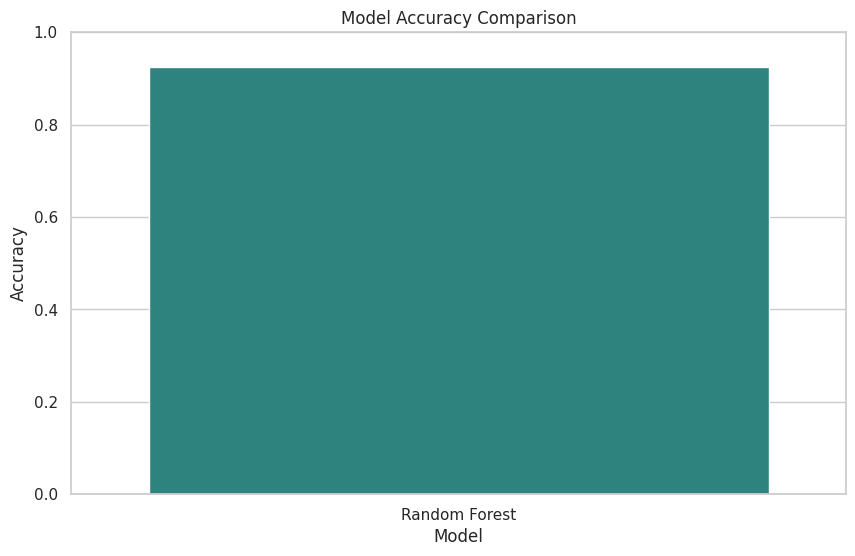

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare visualization data
model_names = ['Random Forest']
accuracies = [rf_accuracy]

# Create DataFrame for visualization
results_df = pd.DataFrame({'Model': model_names, 'Accuracy': accuracies})

# Set up the visualization style
sns.set(style="whitegrid")

# Plot the accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

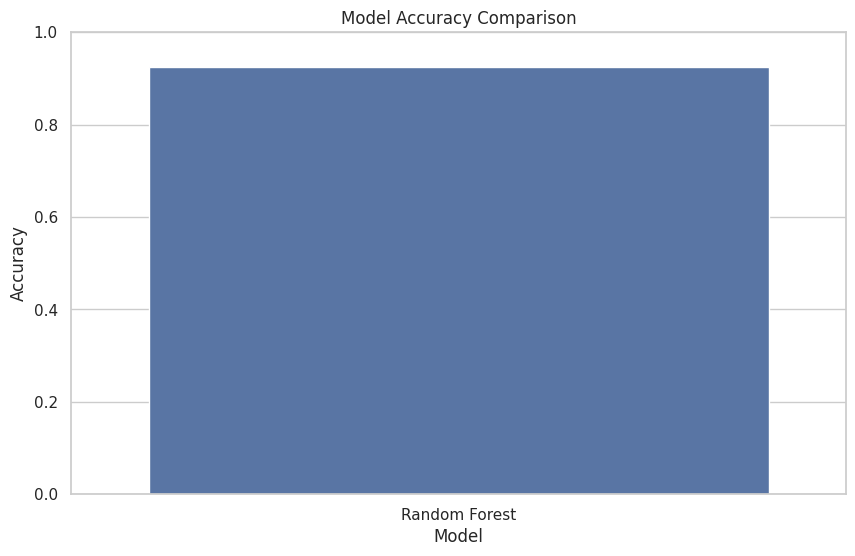

In [41]:
# Visualize model accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, hue='Model', legend=False)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()

In [53]:
from pyspark.ml.feature import VectorAssembler

# Include the necessary columns in your DataFrame for predictions
train_data = df_cleaned.select("Visibility(mi)", "Severity", *feature_columns)  # Include essential columns
test_data = df_cleaned.select("Visibility(mi)", "Severity", *feature_columns)

# Ensure the features are assembled before fitting the model
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create features for training and testing sets
train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

# Now, you can fit your model as before
rf_model = rf.fit(train_data)

In [54]:
# Make predictions on test_data
rf_predictions = rf_model.transform(test_data)

# Now, show predictions along with Visibility and Severity columns
rf_predictions.select("Visibility(mi)", "Severity", "prediction").show(10)


+--------------+--------+----------+
|Visibility(mi)|Severity|prediction|
+--------------+--------+----------+
|           7.0|       2|       2.0|
|           4.0|       2|       2.0|
|           4.0|       2|       2.0|
|           9.0|       2|       2.0|
|           3.0|       3|       2.0|
|           3.0|       3|       2.0|
|           3.0|       2|       2.0|
|           3.0|       2|       2.0|
|           4.0|       3|       2.0|
|           4.0|       2|       2.0|
+--------------+--------+----------+
only showing top 10 rows



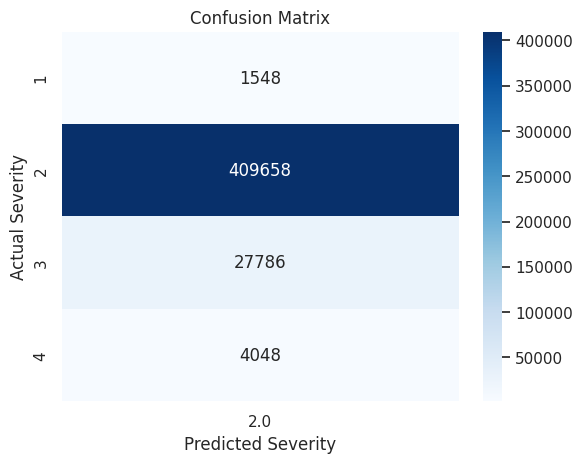

In [55]:
# Get predictions and actual labels
pd_prediction_df = rf_predictions.select("Severity", "prediction").toPandas()

# Create the confusion matrix
confusion_matrix = pd.crosstab(pd_prediction_df['Severity'], pd_prediction_df['prediction'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Severity')
plt.ylabel('Actual Severity')
plt.show()

In [61]:
# Map Severity to binary values (if applicable)
# For example, map severity >= 2 to 1 (accident occurred) and < 2 to 0 (no accident).
from pyspark.sql.functions import when

df_cleaned = df_cleaned.withColumn("Severity", when(F.col("Severity") >= 2, 1).otherwise(0))

# Proceed with the rest of the workflow from Step 1


In [62]:
from pyspark.ml.feature import VectorAssembler

# Prepare the feature columns and the target variable
feature_columns = ["Distance(mi)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Start_Hour"]
target_variable = "Severity"

# Create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_final = assembler.transform(df_cleaned.select(*feature_columns, target_variable))


In [63]:
# Split the data into training and testing sets (70% training, 30% testing)
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)


In [64]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol=target_variable, featuresCol="features", numTrees=100)

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)

In [65]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="features")

# Fit the model on the training data
dt_model = dt.fit(train_data)

# Make predictions on the test dataset
dt_predictions = dt_model.transform(test_data)
dt_accuracy = evaluator.evaluate(dt_predictions)


In [66]:
from pyspark.ml.classification import LinearSVC

# Initialize the Support Vector Classifier
svm = LinearSVC(labelCol=target_variable, featuresCol="features")

# Fit the model on the training data
svm_model = svm.fit(train_data)

# Make predictions on the test dataset
svm_predictions = svm_model.transform(test_data)
svm_accuracy = evaluator.evaluate(svm_predictions)


24/08/05 03:54:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/05 03:54:13 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/08/05 03:54:24 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 
24/08/05 03:54:24 ERROR OWLQN: Failure! Resetting history: breeze.optimize.NaNHistory: 


In [67]:
accuracies = {
    'Random Forest': rf_accuracy,
    'Decision Tree': dt_accuracy,
    'Support Vector Machine': svm_accuracy,
}

# Convert to DataFrame for easier plotting
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())

# Prepare visualization data
results_df = pd.DataFrame({'Model': model_names, 'Accuracy': model_accuracies})


/tmp/ipykernel_6148/830576446.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')


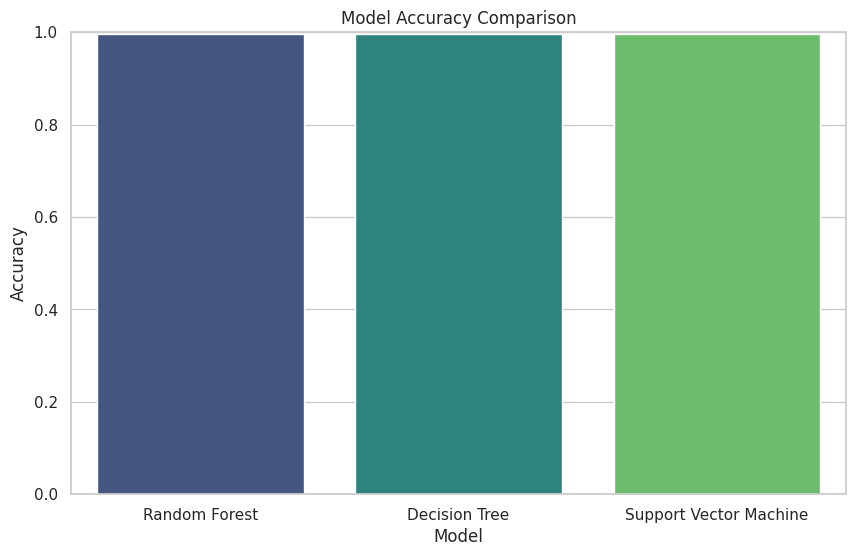

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the visualization style
sns.set(style="whitegrid")

# Plot model accuracy comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Set y-axis limits from 0 to 1
plt.show()


In [69]:
# Show predictions with actual vs predicted values for Random Forest
rf_predictions.select("Visibility(mi)", "Severity", "prediction").show(10)

# Similarly for other models:
dt_predictions.select("Visibility(mi)", "Severity", "prediction").show(10)
svm_predictions.select("Visibility(mi)", "Severity", "prediction").show(10)


+--------------+--------+----------+
|Visibility(mi)|Severity|prediction|
+--------------+--------+----------+
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
+--------------+--------+----------+
only showing top 10 rows



+--------------+--------+----------+
|Visibility(mi)|Severity|prediction|
+--------------+--------+----------+
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
+--------------+--------+----------+
only showing top 10 rows



+--------------+--------+----------+
|Visibility(mi)|Severity|prediction|
+--------------+--------+----------+
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|           0.0|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
|          0.12|       1|       1.0|
+--------------+--------+----------+
only showing top 10 rows



In [82]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Prepare the feature columns and the target variable
feature_columns = ["Distance(mi)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)", "Start_Hour"]
target_variable = "Severity"

# Create feature vector (for df_cleaned DataFrame which should remain consistent)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_final = assembler.transform(df_cleaned.select(*feature_columns, target_variable))

# Split the data into training and testing sets (70% training, 30% testing)
train_data, test_data = df_final.randomSplit([0.7, 0.3], seed=42)

# ------------------------------------------
# Decision Tree Model
# Initialize the Decision Tree Classifier
dt = DecisionTreeClassifier(labelCol=target_variable, featuresCol="features")

# Fit the model on the training data
dt_model = dt.fit(train_data)

# Make predictions on the test dataset
dt_predictions = dt_model.transform(test_data)

# Evaluate the Decision Tree model's accuracy
evaluator = MulticlassClassificationEvaluator(labelCol=target_variable, predictionCol="prediction", metricName="accuracy")
dt_accuracy = evaluator.evaluate(dt_predictions)

print(f"Decision Tree Test Accuracy = {dt_accuracy:.2f}")

# ------------------------------------------
# Random Forest Model (already implemented as you did before)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(labelCol=target_variable, featuresCol="features", numTrees=100)

# Fit the model on the training data
rf_model = rf.fit(train_data)

# Make predictions on the test dataset
rf_predictions = rf_model.transform(test_data)

# Evaluate the Random Forest model's accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)

print(f"Random Forest Test Accuracy = {rf_accuracy:.2f}")

# ------------------------------------------
# Support Vector Machine Model
# Initialize the Support Vector Classifier
svm = LinearSVC(labelCol=target_variable, featuresCol="features")

# Fit the model on the training data
svm_model = svm.fit(train_data)

# Make predictions on the test dataset
svm_predictions = svm_model.transform(test_data)

# Evaluate the SVM model's accuracy
svm_accuracy = evaluator.evaluate(svm_predictions)

print(f"SVM Test Accuracy = {svm_accuracy:.2f}")


24/08/05 04:38:51 ERROR Executor: Exception in task 1.0 in stage 528.0 (TID 998)
org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4111/0x00007fd21d3b5360`: (struct<Distance(mi):double,Visibility(mi):double,Wind_Speed(mph):double,Precipitation(in):double,Start_Hour:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$G

Py4JJavaError: An error occurred while calling o2692.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 528.0 failed 1 times, most recent failure: Lost task 0.0 in stage 528.0 (TID 997) (ip-172-31-23-195.ec2.internal executor driver): org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4111/0x00007fd21d3b5360`: (struct<Distance(mi):double,Visibility(mi):double,Wind_Speed(mph):double,Precipitation(in):double,Start_Hour:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 20 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
Caused by: org.apache.spark.SparkException: [FAILED_EXECUTE_UDF] Failed to execute user defined function (`VectorAssembler$$Lambda$4111/0x00007fd21d3b5360`: (struct<Distance(mi):double,Visibility(mi):double,Wind_Speed(mph):double,Precipitation(in):double,Start_Hour:double>) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>).
	at org.apache.spark.sql.errors.QueryExecutionErrors$.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala:198)
	at org.apache.spark.sql.errors.QueryExecutionErrors.failedExecuteUserDefinedFunctionError(QueryExecutionErrors.scala)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.sort_addToSorter_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.hashAgg_doAggregateWithoutKey_0$(Unknown Source)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenEvaluatorFactory$WholeStageCodegenPartitionEvaluator$$anon$1.hasNext(WholeStageCodegenEvaluatorFactory.scala:43)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:460)
	at org.apache.spark.shuffle.sort.BypassMergeSortShuffleWriter.write(BypassMergeSortShuffleWriter.java:140)
	at org.apache.spark.shuffle.ShuffleWriteProcessor.write(ShuffleWriteProcessor.scala:59)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:104)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:54)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1136)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:635)
	at java.base/java.lang.Thread.run(Thread.java:840)
Caused by: org.apache.spark.SparkException: Encountered null while assembling a row with handleInvalid = "error". Consider
removing nulls from dataset or using handleInvalid = "keep" or "skip".
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1(VectorAssembler.scala:291)
	at org.apache.spark.ml.feature.VectorAssembler$.$anonfun$assemble$1$adapted(VectorAssembler.scala:260)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.WrappedArray.foreach(WrappedArray.scala:38)
	at org.apache.spark.ml.feature.VectorAssembler$.assemble(VectorAssembler.scala:260)
	at org.apache.spark.ml.feature.VectorAssembler.$anonfun$transform$6(VectorAssembler.scala:143)
	... 20 more


In [83]:
# Count nulls in the relevant feature columns
null_counts = df_cleaned.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in feature_columns])
null_counts.show()


+------------+--------------+---------------+-----------------+----------+
|Distance(mi)|Visibility(mi)|Wind_Speed(mph)|Precipitation(in)|Start_Hour|
+------------+--------------+---------------+-----------------+----------+
|           0|          5908|          20875|            97481|         0|
+------------+--------------+---------------+-----------------+----------+



In [84]:
# Fill null values with 0 or another appropriate strategy
df_cleaned = df_cleaned.fillna({
    "Distance(mi)": 0.0,
    "Visibility(mi)": 0.0,
    "Wind_Speed(mph)": 0.0,
    "Precipitation(in)": 0.0,
    "Start_Hour": 0,  # Assuming 0 is appropriate for Start_Hour
    # Add any other needed columns here
})


In [85]:
df_cleaned = df_cleaned.na.drop(subset=feature_columns)


In [86]:
from pyspark.ml.feature import VectorAssembler

# Ensure there are no nulls in feature columns
print("Available Columns in df_cleaned:", df_cleaned.columns)  # Check to confirm columns

# Create feature vector
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")
df_final = assembler.transform(df_cleaned.select(*feature_columns, target_variable)) 


Available Columns in df_cleaned: ['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Crossing', 'Junction', 'Stop', 'Traffic_Signal', 'Sunrise_Sunset', 'Start_Hour', 'Day_of_Week']


In [92]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Load your cleaned data
data = pd.read_csv('Cleaned_&_Wrangled_data.csv')

# Separate features (X) and target (y)
X = data.drop('Severity', axis=1)  # Assuming 'Severity' is your target variable
y = data['Severity']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train your models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results (optional)
    # results[model_name] = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1': f1}

    # ROC curve
    y_scores = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    auc = roc_auc_score(y_test, y_scores)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')

# Visualize results (example using bar charts)
plt.figure(figsize=(10, 6))
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Performance')
plt.xticks(rotation=45)

for model_name in models.keys():
    # You'll need to replace 'results[model_name]' with your actual stored results
    plt.bar(model_name, results[model_name]['Accuracy'], label='Accuracy')
    plt.bar(model_name, results[model_name]['Precision'], label='Precision')
    plt.bar(model_name, results[model_name]['Recall'], label='Recall')
    plt.bar(model_name, results[model_name]['F1'], label='F1')

plt.legend()
plt.show()

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'Cleaned_&_Wrangled_data.csv'

In [3]:
import pandas as pd
print('File Path:', 'Cleaned_&_Wrangled_data.csv') # Replace with your actual file path
data = pd.read_csv('Cleaned_&_Wrangled_data.csv') 


File Path: Cleaned_&_Wrangled_data.csv


FileNotFoundError: [Errno 2] No such file or directory: 'Cleaned_&_Wrangled_data.csv'